<a href="https://colab.research.google.com/github/darthwaydr007/kaggle/blob/master/toxiccomment_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
if torch.cuda.is_available():    
    print('GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")

GPU: Tesla P100-PCIE-16GB


In [ ]:
from fastai.callbacks import *
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!curl -s https://course.fast.ai/setup/colab | bash
from fastai.text import *
import numpy as np 
import pandas as pd 
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Initial Data Processing

In [ ]:
path = Path('/content/drive/My Drive/kaggle/toxic-comment')

In [ ]:
traindf = pd.read_csv(path/'jigsaw-toxic-comment-train.csv')
#traindf2 = pd.read_csv(path/'jigsaw-unintended-bias-train.csv')
validdf = pd.read_csv(path/'validation.csv')
testdf = pd.read_csv(path/'test.csv')
submit = pd.read_csv(path/'sample_submission.csv')

In [ ]:
traindf.head()

,comment_text,toxic
0,You must be stupid \n\nI am referencing an act...,1
1,"Question \n\nIra, I have a question for you. W...",1
2,", 4 May 2012 (UTC)\n The agreement was at the ...",0
3,I deliberately made this last statement bold a...,0
4,You better pray for your account because I am ...,1


In [ ]:
validdf.head()

,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


In [ ]:
testdf.head()

,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


In [ ]:
traindf = traindf[['comment_text' , 'toxic']]

In [ ]:
traindf['toxic'].value_counts()

0    202165
1     21384
Name: toxic, dtype: int64

In [ ]:
traindf_pos = traindf[traindf['toxic'] == 1]
traindf_neg = traindf[traindf['toxic'] == 0]
print(traindf_pos.head())
print(traindf_neg.head())
print(len(traindf_pos))
print(len(traindf_neg))

                                         comment_text  toxic
6        COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK      1
12  Hey... what is it..\n@ | talk .\nWhat is it......      1
16  Bye! \n\nDon't look, come or think of comming ...      1
42  You are gay or antisemmitian? \n\nArchangel WH...      1
43           FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!      1
                                        comment_text  toxic
0  Explanation\nWhy the edits made under my usern...      0
1  D'aww! He matches this background colour I'm s...      0
2  Hey man, I'm really not trying to edit war. It...      0
3  "\nMore\nI can't make any real suggestions on ...      0
4  You, sir, are my hero. Any chance you remember...      0
21384
202165


In [ ]:
traindf_neg = traindf_neg[:30000]
len(traindf_neg)

30000

In [ ]:
traindf = pd.concat([traindf_neg , traindf_pos])
traindf.head()

,comment_text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
traindf = traindf.sample(frac=1).reset_index(drop=True)
traindf.head()

,comment_text,toxic
0,You must be stupid \n\nI am referencing an act...,1
1,"Question \n\nIra, I have a question for you. W...",1
2,", 4 May 2012 (UTC)\n The agreement was at the ...",0
3,I deliberately made this last statement bold a...,0
4,You better pray for your account because I am ...,1


In [ ]:
len(traindf)

51384

In [ ]:
train_lm = pd.concat([traindf , validdf])

In [ ]:
trainlm.isnull().sum()

In [ ]:
type(lm_data)

pandas.core.frame.DataFrame

In [ ]:
'''
from torch.utils.data import TensorDataset, random_split, Dataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

class ToxicDataset(Dataset):
  def __init__(self , df):
    self.length = len(df)
    self.text = df['comment_text'].values
    self.toxic = df['toxic'].values
  def __getitem__(self , index):
    return self.text[index] , self.toxic[index]
  def __len__(self):
    return self.length

train_dataset = ToxicDataset(traindf)
train_loader = DataLoader(dataset = train_dataset , batch_size = 32 , shuffle = True)
'''

In [ ]:
data_lm = TextLMDataBunch.from_df(path = path, 
                             train_df = train_lm ,
                             valid_df = testdf ,
                             text_cols = 0,
                             min_freq=1 ,
                             max_vocab = 80000 ,
                             bs = 32 )

In [ ]:
data_lm.show_batch()

idx,text
0,"page ( and xxmaj joy was aware of them at some point in the past ) xxbos "" \n \n xxmaj ok , let me say it again \n xxmaj come on , now you guys are just being piece of shit jews . i mean you have to admit , the guys in pink floyd play their instruments about as slow as a nigger works . i"
1,xxup the xxup fack xxup is xxup this xxup shit xxbos xxmaj what was the paper called before 1998 ? xxmaj we could put the first editor in the history section and a link in a footnote or at the bottom in the links section to the list of editors . i am fine with those . xxmaj what do you think ? xxbos xxmaj y2kgtp actually reverted the vandalism
2,"be balanced . xxmaj why the arbitrary selected quotes from xxmaj sotomayor and xxmaj dana xxmaj milbank ? xxmaj why xxmaj rush xxmaj limbaugh reaction ? xxmaj since when his fringe views are important to a xxmaj supreme xxmaj court nomination process ( wp : undue , anyone ? xxrep 6 ' mundo "" xxbos "" \n \n xxmaj pretty much what i said the first day this was"
3,"state the true xxup unfiltered truth , but only that , please . \n \n xxmaj aaron - xxmaj zalman xxmaj conflict \n \n xxmaj apparently someone has made this sub - section its own page again . xxmaj thoughts , anyone ? xxmaj is it enough of an issue to have it be its own page , separate from xxmaj satmar the dynasty ? \n xxrep"
4,* 5 الجوائز والتكريمات 5 xxmaj awards and honors \n * 6 أنشطته الأخرى xxmaj six other activities \n * 7 مشاركته في ثورة 25 يناير 7 participating in the revolution of xxmaj january 25 \n * 8 توليه رئاسة وزراء مصر 8 assuming the chairmanship of the xxmaj minister of xxmaj egypt \n * 9 المراجع 9 xxmaj references \n \n [ edit ]


In [ ]:
data_lm.save('data_lm.pkl')

# Language Model Learner

In [ ]:
data_lm = load_data(path, 'data_lm.pkl', bs=64)

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


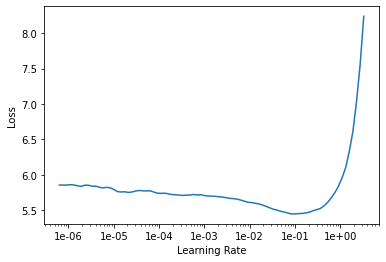

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.274108,4.201923,0.001886,19:40
1,4.159557,4.072734,0.001532,19:44


In [ ]:
learn.save('fit_head')
learn.load('fit_head');

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


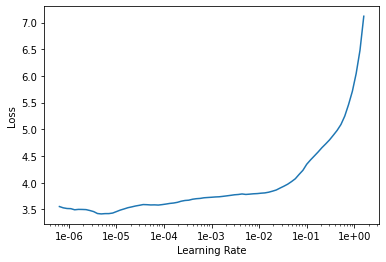

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(3, 1e-3, moms=(0.8,0.7) , 
                    callbacks=[SaveModelCallback(learn, every='epoch', monitor='valid_loss', name='model-fine-tune')])

epoch,train_loss,valid_loss,accuracy,time
0,3.635454,5.388702,0.000839,21:47
1,3.494134,5.852590,0.000839,21:46
2,3.147631,5.901845,0.000816,21:47


In [ ]:
learn.load('model-fine-tune_2');

In [ ]:
TEXT = "I am a"
N_WORDS = 40
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.7) for _ in range(N_SENTENCES)))

I am a new user . i have been editing the page David Duke since i am a user . 
 
  Please stop . If you continue to vandalize pages , as you did to David Duke
I am a sock puppet , i have an account , and i am a sock puppet of a account . Obviously , i am not an admin . You are a sock puppet ! xxbos La House


In [ ]:
learn.save_encoder('fine_tuned_enc')

In [ ]:
train_lm = train_lm[['comment_text' , 'toxic']]
train_lm.head()

,comment_text,toxic
0,You must be stupid \n\nI am referencing an act...,1
1,"Question \n\nIra, I have a question for you. W...",1
2,", 4 May 2012 (UTC)\n The agreement was at the ...",0
3,I deliberately made this last statement bold a...,0
4,You better pray for your account because I am ...,1


In [ ]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train_lm, test_size=0.2)

In [ ]:
test = testdf[['content']]
test.rename(columns = {'content' : 'comment_text'} , inplace = True)
test.head()

,comment_text
0,Doctor Who adlı viki başlığına 12. doctor olar...
1,"Вполне возможно, но я пока не вижу необходимо..."
2,"Quindi tu sei uno di quelli conservativi , ..."
3,Malesef gerçekleştirilmedi ancak şöyle bir şey...
4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...


# Classification

In [1]:
data_cls = TextClasDataBunch.from_df(path,
                                     train_df = train, 
                                     valid_df=valid ,
                                     test_df = test ,
                                     min_freq=1 , 
                                     max_vocab = 80000 ,
                                     bs = 32,
                                     label_cols = 'toxic',
                                     text_cols = 'comment_text' )

NameError: ignored

In [ ]:
data_cls.show_batch()

text,target
xxbos xxmaj take that ! \n \n xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in,1
"xxbos xxup nate , xxup you xxup are xxup fucking xxup god xxup damn xxup fired ! xxup you xxup are xxup fucking xxup fired ! xxup you xxup are xxup fucking xxup fired ! xxup nate , xxup you xxup are xxup fucking xxup god xxup damn xxup fired ! xxup you xxup are xxup fucking xxup fired ! xxup you xxup are xxup fucking xxup fired ! xxup",1
xxbos xxup fuck xxup nigger xxup cunt xxup bitch xxup whore xxup nigger xxup slut xxup cunt xxup cunt xxup fuck xxup fuck xxup nigger xxup cunt xxup bitch xxup whore xxup nigger xxup slut xxup cunt xxup cunt xxup fuck xxup fuck xxup nigger xxup cunt xxup bitch xxup whore xxup nigger xxup slut xxup cunt xxup cunt xxup fuck xxup fuck xxup nigger xxup cunt xxup bitch xxup,1
xxbos i xxup hate xxup wikipedia i xxup hate xxup wikipedia i xxup hate xxup wikipedia i xxup hate xxup wikipedia i xxup hate xxup wikipedia i xxup hate xxup wikipedia i xxup hate xxup wikipedia i xxup hate xxup wikipedia i xxup hate xxup wikipedia i xxup hate xxup wikipedia i xxup hate xxup wikipedia i xxup hate xxup wikipedia i xxup hate xxup wikipedia i xxup hate xxup,1
"xxbos "" \n \n xxmaj origin \n xxmaj parts of this article particularly the "" "" xxmaj origin xxmaj section "" "" not only failed to cite reliable sources , it also left out material facts as regards to the true origin of xxmaj takrur ( also spelt xxmaj tekrur ) . xxmaj in this regard , it totally left out the history of the xxmaj serer people",0


In [ ]:
learn.load_encoder('fine_tuned_enc');

In [ ]:
data_cls.save('data_clas.pkl')

In [ ]:
#learn = text_classifier_learner(data_cls, AWD_LSTM, drop_mult=0.5 , metrics = accuracy, )
learn = text_classifier_learner(data_cls,
                AWD_LSTM,
                drop_mult=0.5,
                metrics=[accuracy], 
                callback_fns=[partial(EarlyStoppingCallback, monitor='accuracy', min_delta=0.01, patience=2)]).to_fp16()


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


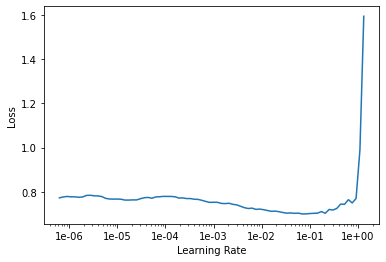

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(2, 5e-2, moms=(0.8,0.7) , 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='cls-head')])

epoch,train_loss,valid_loss,accuracy,time
0,0.579800,0.494372,0.786310,06:53
1,0.510315,0.451651,0.796834,07:02


Better model found at epoch 0 with valid_loss value: 0.49437233805656433.
Better model found at epoch 1 with valid_loss value: 0.45165061950683594.


In [ ]:
learn.load('cls-head');
learn.freeze_to(-2)
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [ ]:
learn.fit_one_cycle(2, slice(4e-2/(2.6**4),4e-2), moms=(0.8,0.7) , 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='cls-(-2)')])

In [ ]:
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 1.74E-02


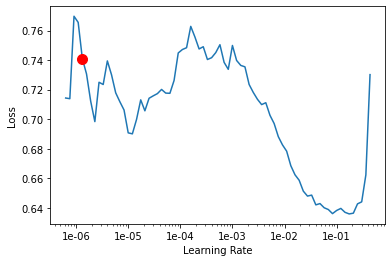

In [ ]:
learn.load('cls-(-2)');
learn.freeze_to(-3)
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [ ]:
learn.fit_one_cycle(3, slice(6e-3/(2.6**4),6e-3), moms=(0.8,0.7),
    callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='cls-(-3)')])

epoch,train_loss,valid_loss,accuracy,time
0,0.361250,0.299879,0.876147,02:32
1,0.283362,0.250521,0.901911,02:43
2,0.210438,0.283926,0.904437,02:42


Better model found at epoch 0 with valid_loss value: 0.29987865686416626.
Better model found at epoch 1 with valid_loss value: 0.2505210041999817.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 4.79E-07


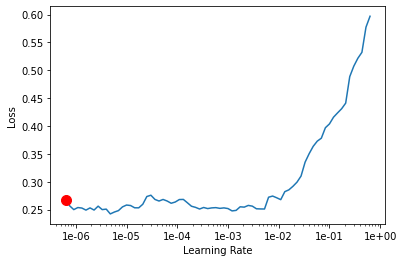

In [ ]:
learn.load('cls-(-3)');
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [ ]:
learn.fit_one_cycle(6, slice(2e-4/(2.6**4),2e-4), moms=(0.8,0.7),
    callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='cls-unfreeze')])

epoch,train_loss,valid_loss,accuracy,time
0,0.239946,0.246746,0.902922,04:05
1,0.229896,0.238990,0.906374,03:51
2,0.200321,0.260007,0.901322,03:34


Better model found at epoch 0 with valid_loss value: 0.2467457801103592.
Better model found at epoch 1 with valid_loss value: 0.23899030685424805.
Epoch 3: early stopping


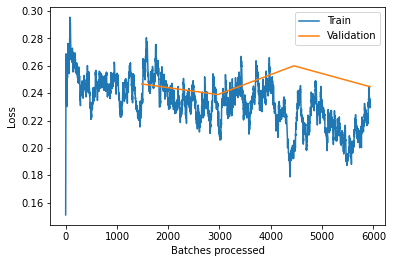

In [ ]:
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


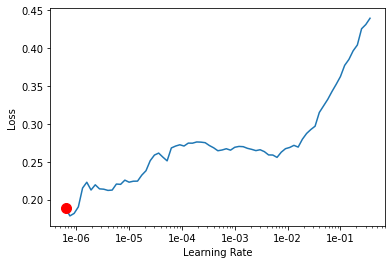

In [ ]:
learn.load('cls-unfreeze');
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [ ]:
learn.fit_one_cycle(6, slice(1e-5/(2.6**4),1e-5), moms=(0.8,0.7),
    callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='cls-unfreeze')])

epoch,train_loss,valid_loss,accuracy,time
0,0.235347,0.243222,0.903427,03:15
1,0.223891,0.266513,0.903848,03:32
2,0.233334,0.243140,0.905953,04:10


Better model found at epoch 0 with valid_loss value: 0.24322174489498138.
Better model found at epoch 2 with valid_loss value: 0.24314042925834656.
Epoch 3: early stopping


In [ ]:
preds, y = learn.get_preds(DatasetType.Test)
preds_np = preds.numpy()

In [ ]:
predictions = pd.DataFrame(preds_np)
predictions.head()

,0,1
0,0.929440,0.070560
1,0.158565,0.841435
2,0.816187,0.183813
3,0.985384,0.014616
4,0.999880,0.000120


In [ ]:
sample = pd.read_csv(path/'sample_submission.csv')
sample.toxic = predictions[1]
sample.head()

In [ ]:
sample.to_csv(path/"submission.csv", index = False)